In [255]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack

In [256]:
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 50

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Define data loaders and data preprocessing steps

In [257]:
data_preprocess = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])


train_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=True, download=True,
                         transform=data_preprocess), 
                    batch_size=batch_size_train, 
                    shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=False, download=True,
                         transform=data_preprocess), 
                    batch_size=batch_size_test, 
                    shuffle=True)

### Define the model

In [260]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.fc1 = nn.Linear((28-(5-1))*(28-(5-1))*10, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc1_drop = nn.Dropout(.50)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, (28-4)*(28-4)*10)
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Define my loss function for weighting adversarial examples

In [261]:
def my_loss(og_output, og_labels, adv_output, adv_labels, alpha=.5):
    """Weight the loss values for original and adversarial examples
    according to hyperparameter alpha. https://arxiv.org/abs/1412.6572
    finds that alpha=.5 works well if the number of original and 
    adversarial examples is equal.
    """
    loss = alpha * F.nll_loss(og_output, og_labels) + (1 - alpha) * F.nll_loss(adv_output, adv_labels)
    return loss

### Define the train and test functions

In [262]:
# utility containers to record how training process goes, used for later visulaztions
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [262]:
def train(epoch, adv=True):
    net.train()
    for batch_idx, (og_samples, og_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        og_output = net(og_samples)
        if adv:
            adv_samples, adv_labels = generate_adversarial_examples(og_samples, og_labels, net)
            adv_output = net(adv_samples)

            loss = my_loss(og_output, og_labels, adv_output, adv_labels)
        else:
            loss = F.nll_loss(og_output, og_labels)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(og_samples), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [263]:
def test(adv=True):
    net.eval()
    
    og_test_loss = 0
    adv_test_loss = 0
    og_correct = 0
    adv_correct = 0
    
    with torch.no_grad():
        for sample, label in test_loader:
            output = net(sample)
            # negative log-likelihood loss
            og_test_loss += F.nll_loss(output, label, reduction='sum').item()
            # output is a tensor, .data retrieves its data, max must return the index of the highest valued element
            pred = output.data.max(1, keepdim=True)[1]
            og_correct += pred.eq(label.data.view_as(pred)).sum()
            
    if adv:
        for og_samples, og_labels in test_loader:
            adv_samples, adv_labels = generate_adversarial_examples(og_samples, og_labels, net, num_per_samp=1)
            adv_output = net(adv_samples)
            # negative log-likelihood loss
            adv_test_loss += F.nll_loss(adv_output, adv_labels, reduction='sum').item()
            # output is a tensor, .data retrieves its data, max must return the index of the highest valued element
            pred = adv_output.data.max(1, keepdim=True)[1]
            adv_correct += pred.eq(label.data.view_as(pred)).sum()
                
    og_test_loss /= len(test_loader.dataset)
    test_losses.append(og_test_loss)
    
    print(f'Test set: Avg. loss: {og_test_loss:.4f}, Accuracy: {og_correct}/{len(test_loader.dataset)} ({100. * og_correct / len(test_loader.dataset):.0f}%)')
    
    og_pcc = 100. * og_correct / len(test_loader.dataset)

    if adv:
        adv_pcc = 100. * adv_correct / len(test_loader.dataset)
        return og_pcc, adv_pcc
    return og_pcc, None

### Define the function to create the adversarial examples

In [264]:
def generate_adversarial_examples(og_samples, true_labels, net, num_per_samp=1):
    """Create num_per_samp adversarial examples for each sample in
    og_samples. Return the generated samples along with corresponding 
    adv_labels, a tensor containing the adversarial examples' labels.
    """
    adversary = LinfPGDAttack(
        net, loss_fn=F.nll_loss, eps=0.15, nb_iter=40, eps_iter=0.01, 
        rand_init=True, clip_min=0.0, clip_max=1.0, targeted=False)
    adv_untargeted = []
    for i in range(num_per_samp):
        adv_untargeted.append(adversary.perturb(og_samples, true_labels))
    adv_untargeted = torch.cat(adv_untargeted, 0)
    adv_labels = torch.cat([true_labels]*num_per_samp, 0)
    return adv_untargeted, adv_labels

### Instantiate the network and train it

In [265]:
# train the model WITHOUT adversarial examples
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(1, n_epochs + 1):
    train(epoch, adv=False)
    og_pcc, adv_pcc = test(adv=True)
    print(f'Test set:\n\tog_pcc = {og_pcc}%\n\tadv_pcc = {adv_pcc}%')
    
# train second version of model WITH adversarial examples
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    
for epoch in range(1, n_epochs + 1):
    train(epoch, adv=True)
    og_pcc, adv_pcc = test(adv=True)
    print(f'Test set:\n\tog_pcc = {og_pcc}%\n\tadv_pcc = {adv_pcc}%')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313135
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.936440
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.368572
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.909730
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.641377
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.779208
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.822016
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.591994
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.341045
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.535080
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.577405
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.353743
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.518327
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.673160
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.697894
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.488234
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.455356
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.307192
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.570571
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.391392
Train Epoch: 1 [12800/60000 (

### Visualize the training / testing results

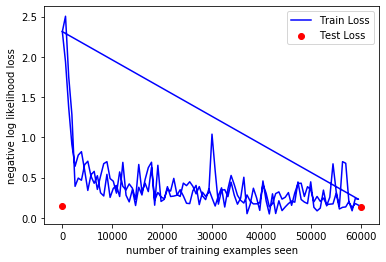

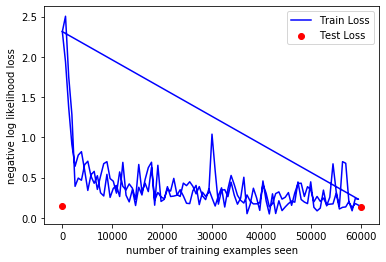

In [266]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig